<a href="https://colab.research.google.com/github/lukasgala19/FINAL_PROJECT/blob/main/Z%C3%A1v%C4%9Bre%C4%8Dn%C3%BD_projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub
import os
from collections import Counter
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from pathlib import Path
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Input,
    Dropout
)
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications import ResNet50V2
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_input_mobilenet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet
from tensorflow.keras.applications.resnet_v2 import preprocess_input as preprocess_input_resnet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [16]:
def plot_history(history):
    """
    Funkce na vykreslení dat z objektu history -> vrací ho metoda fit keras modelu
    """
    # plot the Loss curve(s)
    plt.figure(figsize=[8,6])

    plt.plot(history.history['loss'], 'r', linewidth=3.0)
    plt.plot(history.history['val_loss'], 'b', linewidth=3.0)

    plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title('Loss Curves', fontsize=16)
    plt.show()

    # plot the Accuracy curve(s)
    plt.figure(figsize=[8,6])

    plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
    plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)

    # Nájdeme najlepšiu hodnotu val_accuracy a jej epochu
    best_epoch = np.argmax(history.history['val_accuracy'])  # Epochy s najvyššou presnosťou
    best_val_accuracy = history.history['val_accuracy'][best_epoch]  # Najlepšia hodnota val_accuracy

    # Pridanie bodu pre najlepšiu hodnotu val_accuracy
    plt.scatter(best_epoch, best_val_accuracy, color='green', s=100, zorder=5, label=f'Best val_accuracy: {best_val_accuracy*100:.1f}%')  # S zväčšeným bodom (s=100)

    plt.legend(['Training Accuracy', 'Validation Accuracy', 'Best val_accuracy'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.title('Accuracy Curves', fontsize=16)

    # Pridanie textu s percentuálnou hodnotou a zaokrúhlením na 1 desatinné miesto
    plt.text(best_epoch, best_val_accuracy, f'{best_val_accuracy*100:.1f}%', color='green', ha='right', va='bottom', fontsize=14)

    plt.show()

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [5]:
!kaggle datasets download -d harishkumardatalab/food-image-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/harishkumardatalab/food-image-classification-dataset
License(s): CC0-1.0
food-image-classification-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip -o -q food-image-classification-dataset.zip -d food_data

In [7]:
path = os.path.abspath("food_data")
print("Dataset uložený v:", path)

Dataset uložený v: /content/food_data


In [ ]:
# Nastav správnu cestu k priečinku, kde máš uložené obrázky
data_dir = 'food_data/Food Classification dataset'  # Uisti sa, že je to správna cesta

# Zoznam na uloženie veľkostí obrázkov
image_sizes = []

# Prejdeme cez všetky triedy (podpriečinky)
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        # Prejdeme obrázky v každej triede
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                # Pokúsime sa otvoriť obrázok
                with Image.open(img_path) as img:
                    # Pridáme veľkosť obrázka (šírka, výška)
                    image_sizes.append(img.size)
            except Exception as e:
                print(f"Chyba pri načítaní obrázka {img_path}: {str(e)}")

# Výpis rôznych veľkostí obrázkov
if image_sizes:
    print("Rôzne veľkosti obrázkov:", set(image_sizes))
else:
    print("Neboli nájdené žiadne platné obrázky.")

Rôzne veľkosti obrázkov: {(640, 329), (512, 409), (980, 514), (1200, 1600), (710, 690), (700, 380), (432, 300), (626, 431), (315, 160), (602, 339), (1300, 869), (336, 448), (450, 470), (415, 512), (1600, 1167), (1200, 1456), (1024, 705), (512, 301), (584, 406), (900, 1200), (550, 413), (4032, 2481), (680, 788), (334, 151), (280, 180), (895, 1350), (1200, 674), (1115, 1390), (257, 196), (1600, 1059), (447, 293), (445, 512), (209, 241), (4252, 2834), (600, 800), (1200, 795), (6720, 4480), (298, 169), (209, 277), (3060, 2033), (4000, 3000), (475, 512), (866, 1300), (248, 204), (6000, 3000), (846, 833), (800, 537), (512, 399), (250, 250), (700, 370), (592, 279), (725, 543), (2000, 1500), (1000, 1385), (800, 573), (527, 527), (500, 281), (733, 632), (771, 924), (475, 633), (1600, 1157), (800, 1067), (201, 250), (3072, 4608), (221, 228), (4896, 3672), (660, 535), (186, 270), (600, 404), (640, 440), (2662, 2000), (1200, 628), (550, 403), (707, 1024), (660, 800), (600, 898), (1300, 1389), (136

In [ ]:
# Cesta k priečinku
data_dir = "food_data/Food Classification dataset"

# Získanie podpriečinkov v ceste
subdirectories = os.listdir(data_dir)

# Výpis podpriečinkov
print(subdirectories)

print(len(subdirectories))

['samosa', 'sushi', 'burger', 'idli', 'omelette', 'dal_makhani', 'chapati', 'ice_cream', 'Sandwich', 'apple_pie', 'Crispy Chicken', 'chole_bhature', 'pakode', 'Taco', 'butter_naan', 'kulfi', 'Donut', 'momos', 'cheesecake', 'masala_dosa', 'kadai_paneer', 'Baked Potato', 'Fries', 'pav_bhaji', 'fried_rice', 'jalebi', 'chicken_curry', 'dhokla', 'pizza', 'chai', 'Hot Dog', 'paani_puri', 'Taquito', 'kaathi_rolls']
34


In [ ]:
# Počítadlo obrázkov
image_count = 0

# Prechádzanie všetkých podpriečinkov
for root, dirs, files in os.walk(data_dir):
    # Filtrujeme len súbory, ktoré majú bežné prípony obrázkov
    image_count += sum(1 for file in files if file.lower().endswith(('.png', '.jpg', ".jpeg")))

print(f'Celkový počet obrázkov: {image_count}')

Celkový počet obrázkov: 23873


In [8]:
data_dir_path = Path("food_data/Food Classification dataset")

# Počítanie prípon
extension_counts = Counter(file.suffix.lower() for file in data_dir_path.rglob('*') if file.is_file())

print(extension_counts)

Counter({'.jpg': 12058, '.jpeg': 11780, '.png': 35})


In [9]:
# Cesta k hlavnej zložke
data_dir_path = Path('food_data/Food Classification dataset')

# Overíme, či sa cesta nachádza a či niečo obsahuje
if data_dir_path.exists() and data_dir_path.is_dir():
    print("Cesta k zložke je platná.")
else:
    print("Cesta k zložke neexistuje alebo nie je adresár.")

# Prehľadávanie všetkých súborov s príponou .png v zložkách a podzložkách
png_files = list(data_dir_path.rglob('*.png'))

if png_files:
    print(f"Našli sa {len(png_files)} obrázky vo formáte PNG:")
    for img_path in png_files:
        print(img_path)  # Vytlačí celú cestu k súboru
else:
    print("Nenašli sa žiadne obrázky vo formáte PNG.")

Cesta k zložke je platná.
Našli sa 35 obrázky vo formáte PNG:
food_data/Food Classification dataset/Donut/Donut (33).png
food_data/Food Classification dataset/Donut/Donut (18).png
food_data/Food Classification dataset/Donut/Donut (32).png
food_data/Food Classification dataset/Donut/Donut (19).png
food_data/Food Classification dataset/Donut/Donut (34).png
food_data/Food Classification dataset/Donut/Donut (23).png
food_data/Food Classification dataset/Donut/Donut (13).png
food_data/Food Classification dataset/Donut/Donut (30).png
food_data/Food Classification dataset/Donut/Donut (35).png
food_data/Food Classification dataset/Donut/Donut (36).png
food_data/Food Classification dataset/Donut/Donut (40).png
food_data/Food Classification dataset/Donut/Donut (37).png
food_data/Food Classification dataset/Donut/Donut (2).png
food_data/Food Classification dataset/Donut/Donut (12).png
food_data/Food Classification dataset/Donut/Donut (38).png
food_data/Food Classification dataset/Donut/Donut (1).

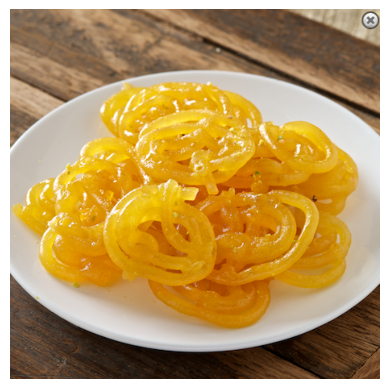

In [ ]:
img_path = Path('food_data/Food Classification dataset/jalebi/018.png')

# Otvorenie obrázka
img = Image.open(img_path)

# Zobrazenie obrázka
plt.imshow(img)
plt.axis('off')  # Vypne osy
plt.show()

In [ ]:
# Cesta k hlavnej zložke
data_dir_path = Path('food_data/Food Classification dataset')

# Overíme, či sa cesta nachádza a či niečo obsahuje
if data_dir_path.exists() and data_dir_path.is_dir():
    print("Cesta k zložke je platná.")
else:
    print("Cesta k zložke neexistuje alebo nie je adresár.")

# Prehľadávanie všetkých súborov s príponou .jpeg v zložkách a podzložkách
jpeg_files = list(data_dir_path.rglob('*.jpeg'))

# Vypíše iba prvých 10 súborov, ak existujú
if jpeg_files:
    print(f"Našli sa {len(jpeg_files)} obrázky vo formáte JPEG:")
    for img_path in jpeg_files[:10]:  # Zoberieme len prvých 10 súborov
        print(img_path)  # Vytlačí celú cestu k súboru
else:
    print("Nenašli sa žiadne obrázky vo formáte JPEG.")

Cesta k zložke je platná.
Našli sa 11780 obrázky vo formáte JPEG:
food_data/Food Classification dataset/Sandwich/Sandwich-Train (367).jpeg
food_data/Food Classification dataset/Sandwich/Sandwich-Train (1026).jpeg
food_data/Food Classification dataset/Sandwich/Sandwich-Train (814).jpeg
food_data/Food Classification dataset/Sandwich/Sandwich-Train (608).jpeg
food_data/Food Classification dataset/Sandwich/Sandwich-Train (736).jpeg
food_data/Food Classification dataset/Sandwich/Sandwich-Train (431).jpeg
food_data/Food Classification dataset/Sandwich/Sandwich-Train (1138).jpeg
food_data/Food Classification dataset/Sandwich/Sandwich-Train (661).jpeg
food_data/Food Classification dataset/Sandwich/Sandwich-Train (479).jpeg
food_data/Food Classification dataset/Sandwich/Sandwich-Train (464).jpeg


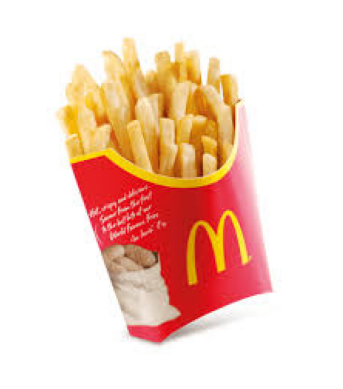

In [ ]:
img_path = Path('food_data/Food Classification dataset/Fries/Fries-Train (859).jpeg')

# Otvorenie obrázka
img = Image.open(img_path)

# Zobrazenie obrázka
plt.imshow(img)
plt.axis('off')  # Vypne osy
plt.show()

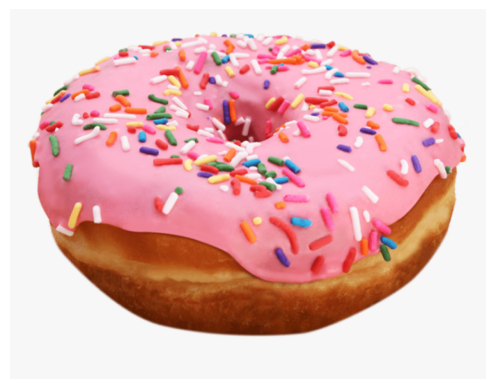

In [20]:
img_path = Path('food_data/Food Classification dataset/Donut/Donut (38).png')

# Otvorenie obrázka
img = Image.open(img_path)

# Zobrazenie obrázka
plt.imshow(img)
plt.axis('off')  # Vypne osy
plt.show()

In [ ]:
#data_dir = "food_data/Food Classification dataset"
#data_dir_path = Path(data_dir)

# Get subdirectories
#subdirectories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# Count total images first (for verification)
total_image_count = 0
for root, dirs, files in os.walk(data_dir):
    total_image_count += sum(1 for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg')))
print(f'Total images counted with os.walk: {total_image_count}')

# Iniciovanie prázdnych zoznamov pre obrázky (X) a ich labely (y)
X = []
y = []
encoding = {}
processed_count = 0
error_count = 0

# Pre každú kategóriu (podadresár)
for index, category in enumerate(subdirectories):
    # Uložíme priradenie indexu k názvu kategórie
    encoding[index] = category

    # Cesta k adresáru s obrázkami konkrétnej kategórie
    folder_path = data_dir_path / category

    # List na uloženie obrázkov tejto kategórie
    image_list = []
    category_count = 0
    category_errors = 0

    # Pre každý súbor v danom adresári
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):  # Case-insensitive check
            try:
                # Cesta k obrázku
                img_path = folder_path / filename

                # Otvorenie obrázka
                img = Image.open(img_path)

                # 1. Ak má obrázok 4 kanály (RGBA), konvertuj ho na RGB
                if img.mode == 'RGBA':
                    img = img.convert('RGB')

                # 2. Ak je obrázok v grayscale alebo má iný formát, konvertuj ho na RGB
                if img.mode != 'RGB':
                    img = img.convert('RGB')

                # 3. Zmena veľkosti na 224x224, aby obrázky mali jednotný rozmer
                img_resized = img.resize((224, 224))

                # Prevod na numpy array
                img_array = np.array(img_resized)

                # Pridanie obrázka do zoznamu pre túto kategóriu
                image_list.append(img_array)
                category_count += 1

            except Exception as e:
                print(f"Error processing {category}/{filename}: {e}")
                category_errors += 1
                error_count += 1

    # Pridanie všetkých obrázkov tejto kategórie do zoznamu X
    X += image_list

    # Priradenie labelu pre každú kategóriu
    y += [index] * len(image_list)

    processed_count += category_count
    print(f"Category {category}: Processed {category_count} images, Errors: {category_errors}")

# Final counts
print(f"\nSummary:")
print(f"Total images counted initially: {total_image_count}")
print(f"Total images processed successfully: {processed_count}")
print(f"Total images with errors: {error_count}")
print(f"Total images processed + errors: {processed_count + error_count}")
print(f"Difference from initial count: {total_image_count - (processed_count + error_count)}")

# Convert lists to numpy arrays for ML processing
X = np.array(X)
y = np.array(y)

print(f"\nFinal dataset shape:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Number of categories: {len(encoding)}")

Total images counted with os.walk: 23873
Category samosa: Processed 244 images, Errors: 0
Category sushi: Processed 1000 images, Errors: 0
Category burger: Processed 331 images, Errors: 0
Category idli: Processed 302 images, Errors: 0
Category omelette: Processed 1000 images, Errors: 0
Category dal_makhani: Processed 295 images, Errors: 0
Category chapati: Processed 327 images, Errors: 0
Category ice_cream: Processed 1000 images, Errors: 0
Category Sandwich: Processed 1500 images, Errors: 0
Category apple_pie: Processed 1000 images, Errors: 0
Category Crispy Chicken: Processed 1500 images, Errors: 0
Category chole_bhature: Processed 376 images, Errors: 0
Category pakode: Processed 269 images, Errors: 0
Category Taco: Processed 1500 images, Errors: 0
Category butter_naan: Processed 307 images, Errors: 0
Category kulfi: Processed 214 images, Errors: 0
Category Donut: Processed 1500 images, Errors: 0
Category momos: Processed 323 images, Errors: 0
Category cheesecake: Processed 1000 image

In [ ]:
len(X)

23873

In [ ]:
len(y)

23873

### ***1X. Trénovanie s použitím MobilenetV2 bez trénovania vrstiev modelu - vidieť značný overfitting (accuracy vs. val_accuracy)***

In [27]:
# Definícia cesty k dátam
data_dir_path = Path("food_data/Food Classification dataset")

# 1. Vytvorte generátory dát
train_datagen_MN2 = ImageDataGenerator(
    preprocessing_function=preprocess_input_mobilenet,
    validation_split=0.2
)

validation_datagen_MN2 = ImageDataGenerator(
    preprocessing_function=preprocess_input_mobilenet,
    validation_split=0.2
)

# 2. Vytvorte generátory pre trénovanie a validáciu
train_generator_MN2 = train_datagen_MN2.flow_from_directory(
    data_dir_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=42,
    shuffle=True,
)

validation_generator_MN2 = validation_datagen_MN2.flow_from_directory(
    data_dir_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=42,
    shuffle=False,
)

# 3. Načítajte model s menšou veľkosťou
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3), alpha=0.75)

# 4. Pridajte klasifikačné vrstvy
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(train_generator_MN2.num_classes, activation='softmax')(x)

# 5. Vytvorte model
model = Model(inputs=base_model.input, outputs=predictions)

# 6. Zmrazte konvolučné vrstvy
for layer in base_model.layers:
    layer.trainable = False

# 7. Kompilujte model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early = EarlyStopping(
    # sleduj přesnost u validačních dat
    monitor="val_accuracy",
    # pokud se nezlepší alespoň o 0.3%
    min_delta=0.005,
    # za posledních 10 epoch
    patience=3,
    # tak to vypni, a načti váhy z epochy, kdy byla nejvyšší přesnost na validačních datech
    restore_best_weights=True,
    start_from_epoch = 1
)

save = ModelCheckpoint(
    # kam uložit model
    filepath="best_model_MN2.keras",
    # sleduj přesnost u validačních dat
    monitor="val_accuracy",
    # ulož vždy jen jeden soubor s nejlepší hodnotou metriky
    save_best_only=True,
    # ulož do jednoho souboru architekturu i váhy
    save_weights_only=False,
    # po každé epoše
    save_freq="epoch"
)


# 8. Trénujte model s generátormi bez parametra workers
history_MN2 = model.fit(
    train_generator_MN2,
    validation_data= validation_generator_MN2,
    epochs=5, callbacks=[early, save]
)

Found 19108 images belonging to 34 classes.
Found 4765 images belonging to 34 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 688/1195 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - accuracy: 0.5706 - loss: 1.5809

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1195/1195 ━━━━━━━━━━━━━━━━━━━━ 136s 108ms/step - accuracy: 0.6219 - loss: 1.3595 - val_accuracy: 0.7872 - val_loss: 0.7160
Epoch 2/5
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 125s 105ms/step - accuracy: 0.8274 - loss: 0.5571 - val_accuracy: 0.7939 - val_loss: 0.6874
Epoch 3/5
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 141s 118ms/step - accuracy: 0.8799 - loss: 0.3796 - val_accuracy: 0.7815 - val_loss: 0.7665
Epoch 4/5
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 148s 124ms/step - accuracy: 0.9118 - loss: 0.2670 - val_accuracy: 0.8019 - val_loss: 0.7014
Epoch 5/5
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 135s 113ms/step - accuracy: 0.9488 - loss: 0.1644 - val_accuracy: 0.8063 - val_loss: 0.7710


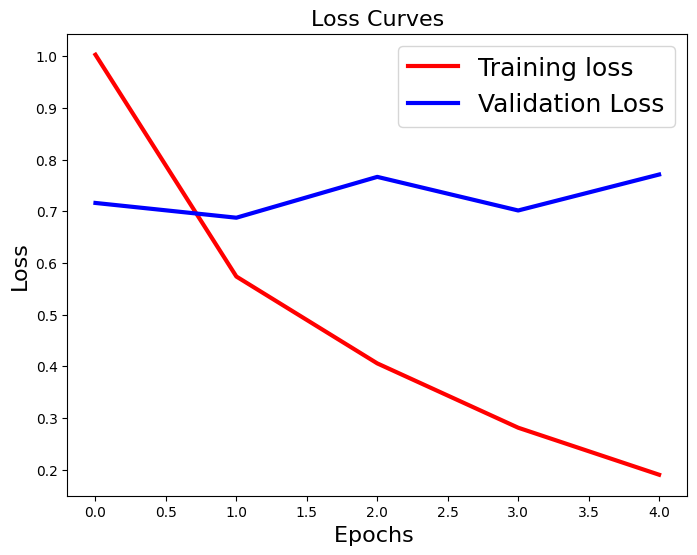

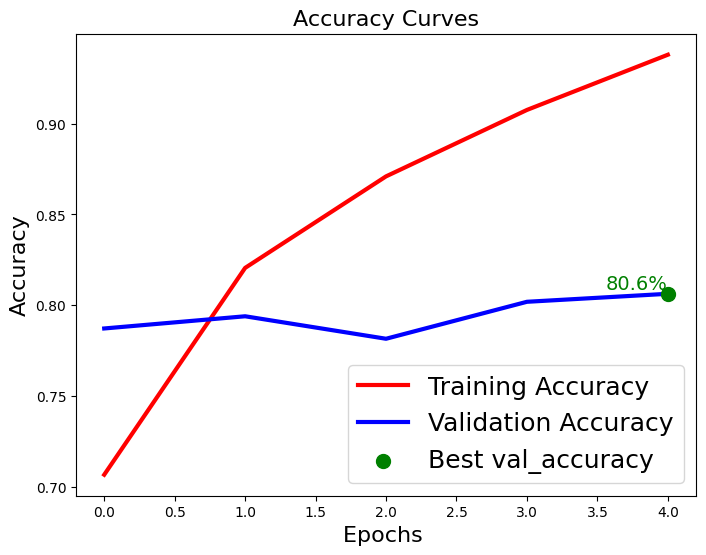

In [29]:
plot_history(history_MN2)

### ***3X.Trénovanie s použitím MobilenetV2 bez trénovania vrstiev modelu s použitím regularizácie***

In [12]:
data_dir_path = Path("food_data/Food Classification dataset")

# 1. Vytvorte generátor dát s augmentáciou
train_datagen_MN2R = ImageDataGenerator(
    preprocessing_function=preprocess_input_mobilenet,
    validation_split=0.2,
    rotation_range=20,          # náhodná rotácia do 20 stupňov
    width_shift_range=0.2,      # náhodný posun horizontálne
    height_shift_range=0.2,     # náhodný posun vertikálne
    shear_range=0.2,            # náhodná deformácia
    zoom_range=0.2,             # náhodné priblíženie
    horizontal_flip=True        # náhodné horizontálne prevrátenie
)

# Pre validačné dáta nepoužívame augmentáciu
validation_datagen_MN2R = ImageDataGenerator(
    preprocessing_function=preprocess_input_mobilenet,
    validation_split=0.2
)

# 2. Vytvorte generátory pre trénovanie a validáciu
train_generator_MN2R = train_datagen_MN2R.flow_from_directory(
    data_dir_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=42,
    shuffle=True,
)

validation_generator_MN2R = validation_datagen_MN2R.flow_from_directory(
    data_dir_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=42,
    shuffle=False,
)

# 3. Načítajte model s menšou veľkosťou
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3), alpha=0.75)

# 4. Pridajte klasifikačné vrstvy s regularizáciou
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Pridanie BatchNormalization a Dropout
x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # 50% dropout

# Výstupná vrstva s L2 regularizáciou
predictions = Dense(
    train_generator_MN2R.num_classes,
    activation='softmax',
    kernel_regularizer=l2(0.001)
)(x)

# 5. Vytvorte model
model = Model(inputs=base_model.input, outputs=predictions)

# 6. Zmrazte konvolučné vrstvy
for layer in base_model.layers:
    layer.trainable = False

# 7. Kompilujte model
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Znížená learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early = EarlyStopping(
    # sleduj přesnost u validačních dat
    monitor="val_accuracy",
    # pokud se nezlepší alespoň o 0.5%
    min_delta=0.005,
    # za posledních 10 epoch
    patience=3,
    # tak to vypni, a načti váhy z epochy, kdy byla nejvyšší přesnost na validačních datech
    restore_best_weights=True,
    start_from_epoch = 1
)

save = ModelCheckpoint(
    # kam uložit model
    filepath="best_model_MN2R.keras",
    # sleduj přesnost u validačních dat
    monitor="val_accuracy",
    # ulož vždy jen jeden soubor s nejlepší hodnotou metriky
    save_best_only=True,
    # ulož do jednoho souboru architekturu i váhy
    save_weights_only=False,
    # po každé epoše
    save_freq="epoch"
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_delta=0.001,
    min_lr=0.00001
)

# 9. Trénujte model s callback-mi
history_MN2R = model.fit(
    train_generator_MN2R,
    validation_data=validation_generator_MN2R,
    epochs=5,  # Zvýšený počet epoch, ale early stopping môže zastaviť skôr
    callbacks=[early, reduce_lr, save]
)

Found 19108 images belonging to 34 classes.
Found 4765 images belonging to 34 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 815/1195 ━━━━━━━━━━━━━━━━━━━━ 1:27 230ms/step - accuracy: 0.4102 - loss: 3.2460

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1195/1195 ━━━━━━━━━━━━━━━━━━━━ 334s 269ms/step - accuracy: 0.4497 - loss: 3.0313 - val_accuracy: 0.7498 - val_loss: 1.6725 - learning_rate: 5.0000e-04
Epoch 2/5
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 298s 249ms/step - accuracy: 0.6661 - loss: 1.9273 - val_accuracy: 0.7656 - val_loss: 1.5336 - learning_rate: 5.0000e-04
Epoch 3/5
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 302s 253ms/step - accuracy: 0.6966 - loss: 1.7217 - val_accuracy: 0.7763 - val_loss: 1.4359 - learning_rate: 5.0000e-04
Epoch 4/5
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 304s 255ms/step - accuracy: 0.7110 - loss: 1.5964 - val_accuracy: 0.7767 - val_loss: 1.3416 - learning_rate: 5.0000e-04
Epoch 5/5
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 312s 261ms/step - accuracy: 0.7211 - loss: 1.5050 - val_accuracy: 0.7857 - val_loss: 1.3013 - learning_rate: 5.0000e-04


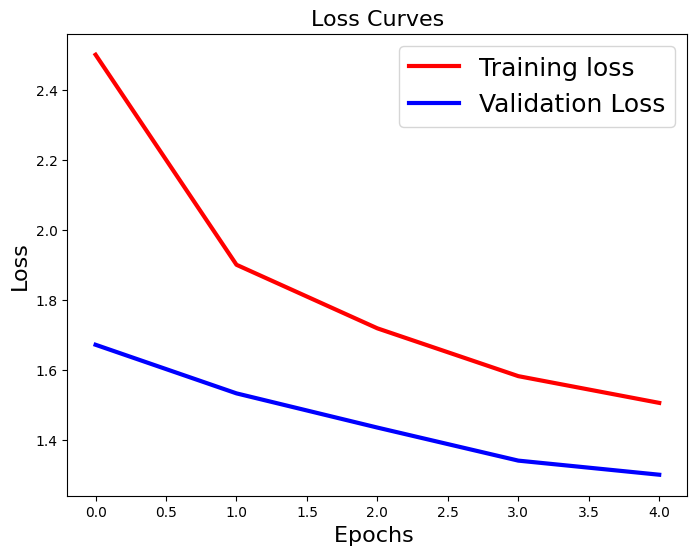

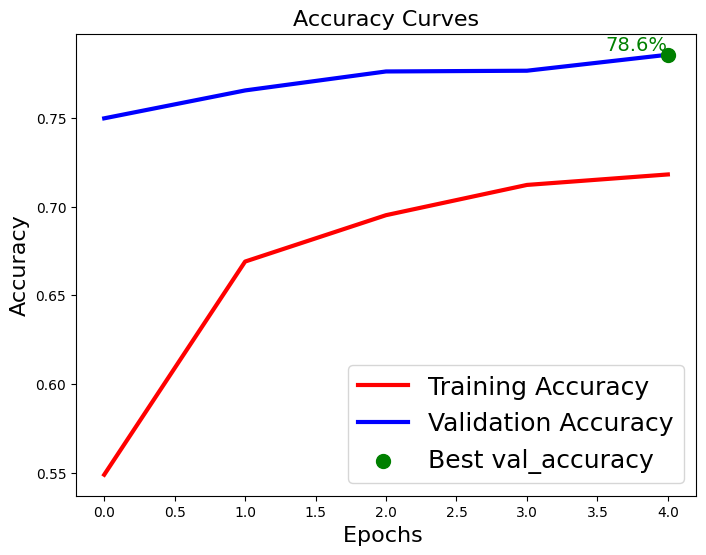

In [17]:
plot_history(history_MN2R)

298/298 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step


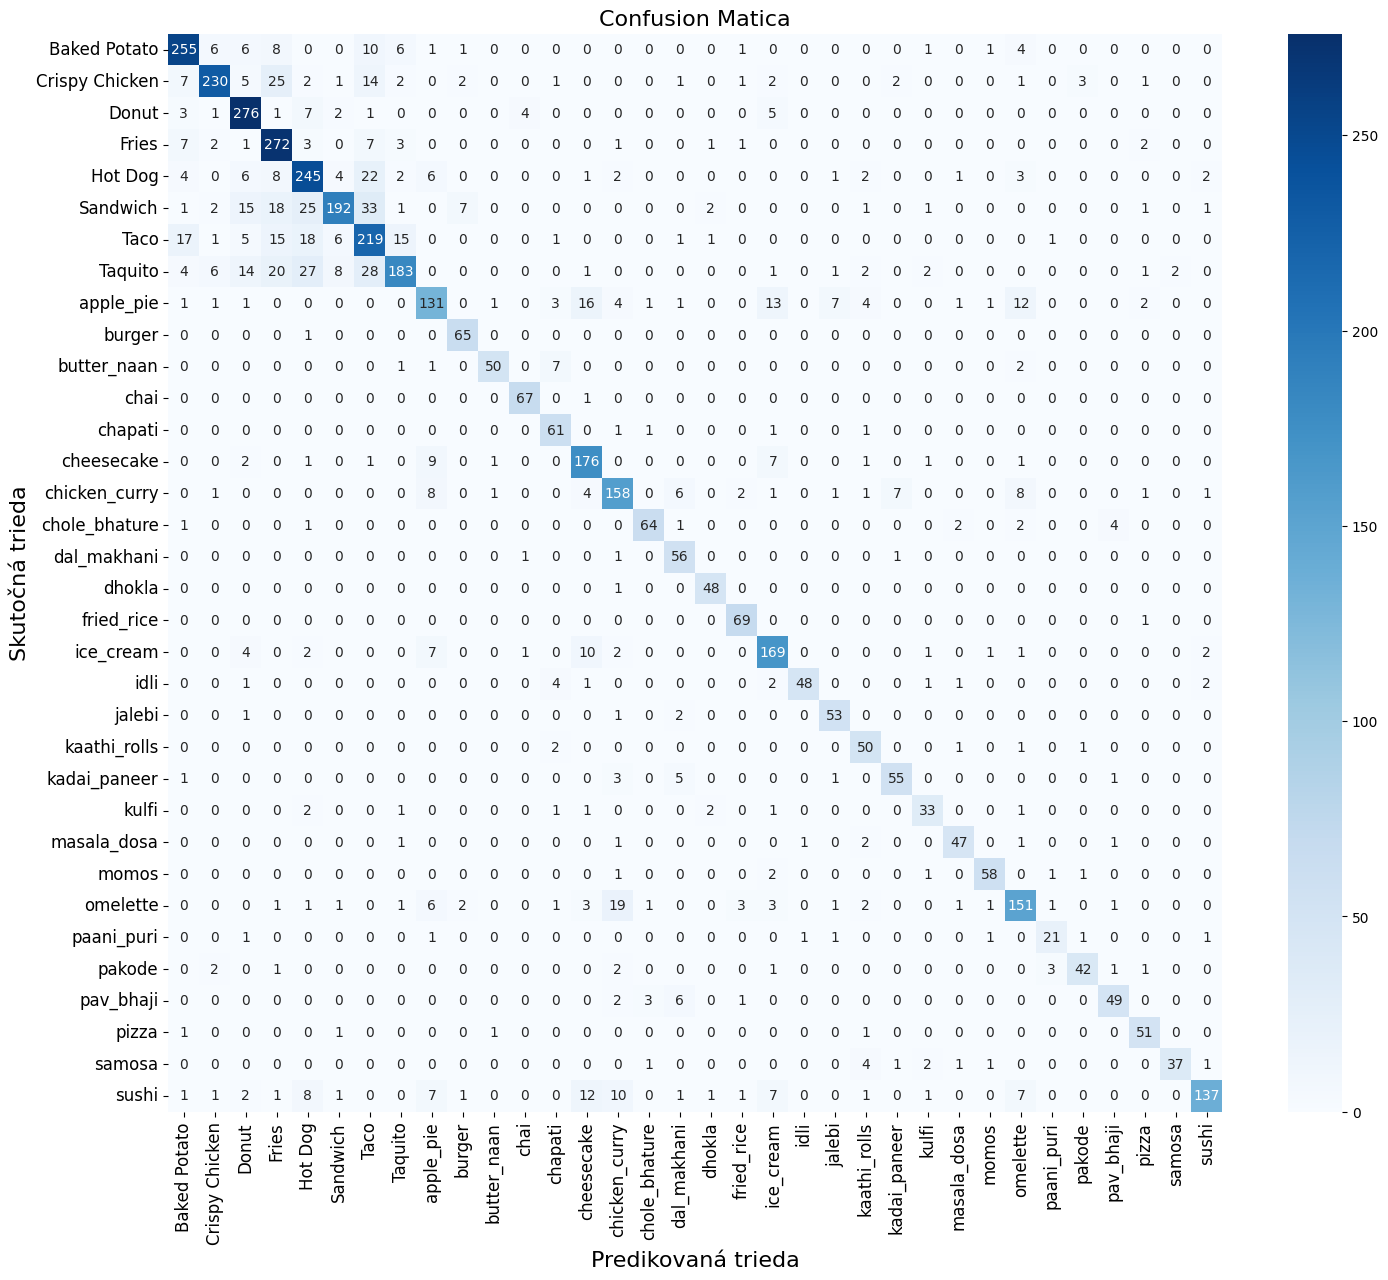

In [22]:
# 1. Získanie predikcií na validačných dátach
y_pred_probs_MN2R = model.predict(validation_generator_MN2R)  # Predikované pravdepodobnosti
y_pred_classes_MN2R = np.argmax(y_pred_probs, axis=1)   # Index triedy s najvyššou pravdepodobnosťou

# 2. Skutočné triedy
y_true_MN2R = validation_generator_MN2R.classes

# 3. Vytvorenie confusion matice
cm_MN2R = confusion_matrix(y_true, y_pred_classes)
class_labels_MN2R = list(validation_generator_MN2R.class_indices.keys())  # Názvy tried

# 4. Vizualizácia pomocou seaborn
plt.figure(figsize=(17, 14))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels_MN2R, yticklabels=class_labels_MN2R)
plt.xlabel("Predikovaná trieda",fontsize=16)
plt.ylabel("Skutočná trieda",fontsize=16)
plt.title("Confusion Matica",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

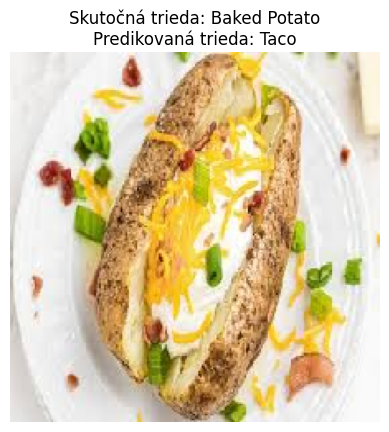

Obrázok 10 - Skutočná trieda: Baked Potato, Predikovaná trieda: Taco


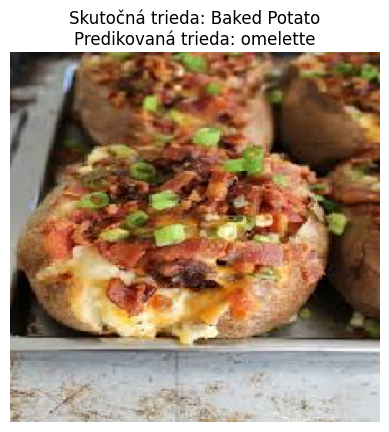

Obrázok 13 - Skutočná trieda: Baked Potato, Predikovaná trieda: omelette


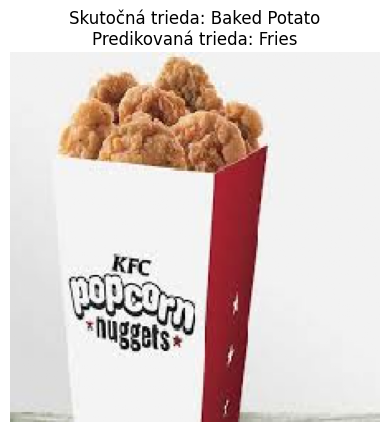

Obrázok 20 - Skutočná trieda: Baked Potato, Predikovaná trieda: Fries


In [28]:
# 3. Zistenie nesprávne klasifikovaných obrázkov
incorrect_indices_MN2R = np.where(y_true != y_pred_classes_MN2R)[0]

# 4. Výpis prvých 5 nesprávne klasifikovaných obrázkov
for idx in incorrect_indices_MN2R[:3]:  # Zobrazí len prvých 5 nesprávne klasifikovaných obrázkov
    true_class_MN2R = list(validation_generator_MN2R.class_indices.keys())[list(validation_generator_MN2R.class_indices.values()).index(y_true[idx])]
    predicted_class_MN2R = list(validation_generator_MN2R.class_indices.keys())[list(validation_generator_MN2R.class_indices.values()).index(y_pred_classes[idx])]

    # Načítanie obrázka
    img, label = validation_generator_MN2R[idx]  # Načítanie obrázka a jeho skutočnej triedy

    # Upravenie rozsahu obrázka, ak sú hodnoty v rozsahu [-1, 1], upravíme ich na [0, 1]
    img = (img + 1) / 2  # Premeníme hodnoty z [-1, 1] na [0, 1]

    # Zobrazenie obrázka
    plt.imshow(img[0])  # Zobrazí len prvý obrázok z batchu
    plt.title(f"Skutočná trieda: {true_class_MN2R}\nPredikovaná trieda: {predicted_class_MN2R}")
    plt.axis('off')  # Skrytie osí
    plt.show()

    print(f"Obrázok {idx} - Skutočná trieda: {true_class_MN2R}, Predikovaná trieda: {predicted_class_MN2R}")

In [25]:
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

                precision    recall  f1-score   support

  Baked Potato       0.84      0.85      0.85       300
Crispy Chicken       0.91      0.77      0.83       300
         Donut       0.81      0.92      0.86       300
         Fries       0.74      0.91      0.81       300
       Hot Dog       0.71      0.79      0.75       309
      Sandwich       0.89      0.64      0.74       300
          Taco       0.65      0.73      0.69       300
       Taquito       0.85      0.61      0.71       300
     apple_pie       0.74      0.66      0.69       200
        burger       0.83      0.98      0.90        66
   butter_naan       0.93      0.82      0.87        61
          chai       0.92      0.99      0.95        68
       chapati       0.75      0.94      0.84        65
    cheesecake       0.78      0.88      0.83       200
 chicken_curry       0.76      0.79      0.77       200
 chole_bhature       0.90      0.85      0.88        75
   dal_makhani       0.70      0.95      0.81  

### ***4. Trénovanie s použitím EfficientNetB2 bez trénovania vrstiev modelu - vidieť značný overfitting (accuracy vs. val_accuracy)***

In [ ]:
# Definícia cesty k dátam
data_dir_path = Path("food_data/Food Classification dataset")

# 1. Vytvorte generátory dát
train_datagen_ENB2 = ImageDataGenerator(
    preprocessing_function = preprocess_input_efficientnet,
    validation_split=0.2
)

validation_datagen_ENB2 = ImageDataGenerator(
    preprocessing_function = preprocess_input_efficientnet,
    validation_split=0.2
)

# 2. Vytvorte generátory pre trénovanie a validáciu
train_generator_ENB2 = train_datagen_ENB2.flow_from_directory(
    data_dir_path,
    target_size=(260, 260),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=42,
    shuffle=True,
)

validation_generator_ENB2 = validation_datagen_ENB2.flow_from_directory(
    data_dir_path,
    target_size=(260, 260),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=42,
    shuffle=False,
)

# 3. Načítajte EfficientNetB2 model namiesto MobileNetV2
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(260, 260, 3))

# 4. Pridajte klasifikačné vrstvy
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(train_generator_ENB2.num_classes, activation='softmax')(x)

# 5. Vytvorte model
model = Model(inputs=base_model.input, outputs=predictions)

# 6. Zmrazte konvolučné vrstvy
for layer in base_model.layers:
    layer.trainable = False

# 7. Kompilujte model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early = EarlyStopping(
    # sleduj přesnost u validačních dat
    monitor="val_accuracy",
    # pokud se nezlepší alespoň o 0.3%
    min_delta=0.005,
    # za posledních 10 epoch
    patience=3,
    # tak to vypni, a načti váhy z epochy, kdy byla nejvyšší přesnost na validačních datech
    restore_best_weights=True,
    start_from_epoch = 1
)

save = ModelCheckpoint(
    # kam uložit model
    filepath="best_model_ENB2.keras",
    # sleduj přesnost u validačních dat
    monitor="val_accuracy",
    # ulož vždy jen jeden soubor s nejlepší hodnotou metriky
    save_best_only=True,
    # ulož do jednoho souboru architekturu i váhy
    save_weights_only=False,
    # po každé epoše
    save_freq="epoch"
)


# 8. Trénujte model s generátormi bez parametra workers
history_ENB2 = model.fit(
    train_generator_ENB2,
    validation_data=validation_generator_ENB2,
    epochs=5, callbacks=[early, save]
)

Found 19108 images belonging to 34 classes.
Found 4765 images belonging to 34 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 468/1195 ━━━━━━━━━━━━━━━━━━━━ 1:18 108ms/step - accuracy: 0.6216 - loss: 1.4064

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1195/1195 ━━━━━━━━━━━━━━━━━━━━ 195s 138ms/step - accuracy: 0.7062 - loss: 1.0537 - val_accuracy: 0.8583 - val_loss: 0.4834
Epoch 2/5
  91/1195 ━━━━━━━━━━━━━━━━━━━━ 1:33 85ms/step - accuracy: 0.8821 - loss: 0.3456

In [ ]:
plot_history(history_ENB2)

### ***6.Trénovanie s použitím EfficientNetB2 bez trénovania vrstiev modelu s použitím regularizácie (shape = 260,260,3)***

In [ ]:
data_dir_path = Path("food_data/Food Classification dataset")

# 1. Vytvorte generátor dát s augmentáciou
train_datagen_ENB2R = ImageDataGenerator(
    preprocessing_function=preprocess_input_efficientnet,
    validation_split=0.2,
    rotation_range=20,          # náhodná rotácia do 20 stupňov
    width_shift_range=0.2,      # náhodný posun horizontálne
    height_shift_range=0.2,     # náhodný posun vertikálne
    shear_range=0.2,            # náhodná deformácia
    zoom_range=0.2,             # náhodné priblíženie
    horizontal_flip=True        # náhodné horizontálne prevrátenie
)

# Pre validačné dáta nepoužívame augmentáciu
validation_datagen_ENB2R = ImageDataGenerator(
    preprocessing_function=preprocess_input_efficientnet,
    validation_split=0.2
)

# 2. Vytvorte generátory pre trénovanie a validáciu
train_generator_ENB2R = train_datagen_ENB2R.flow_from_directory(
    data_dir_path,
    target_size=(260, 260),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

validation_generator_ENB2R = validation_datagen_ENB2R.flow_from_directory(
    data_dir_path,
    target_size=(260, 260),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

# 3. Načítajte model s menšou veľkosťou
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(260, 260, 3))

# 4. Pridajte klasifikačné vrstvy s regularizáciou
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Pridanie BatchNormalization a Dropout
x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # 50% dropout

# Výstupná vrstva s L2 regularizáciou
predictions = Dense(
    train_generator_ENB2R.num_classes,
    activation='softmax',
    kernel_regularizer=l2(0.001)
)(x)

# 5. Vytvorte model
model = Model(inputs=base_model.input, outputs=predictions)

# 6. Zmrazte konvolučné vrstvy
for layer in base_model.layers:
    layer.trainable = False

# 7. Kompilujte model
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Znížená learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early = EarlyStopping(
    # sleduj přesnost u validačních dat
    monitor="val_accuracy",
    # pokud se nezlepší alespoň o 0.5%
    min_delta=0.005,
    # za posledních 10 epoch
    patience=3,
    # tak to vypni, a načti váhy z epochy, kdy byla nejvyšší přesnost na validačních datech
    restore_best_weights=True,
    start_from_epoch = 1
)

save = ModelCheckpoint(
    # kam uložit model
    filepath="best_model_ENB2R.keras",
    # sleduj přesnost u validačních dat
    monitor="val_accuracy",
    # ulož vždy jen jeden soubor s nejlepší hodnotou metriky
    save_best_only=True,
    # ulož do jednoho souboru architekturu i váhy
    save_weights_only=False,
    # po každé epoše
    save_freq="epoch"
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_delta=0.001,
    min_lr=0.00001
)

# 9. Trénujte model s callback-mi
history = model.fit(
    train_generator_ENB2R,
    validation_data=validation_generator_ENB2R,
    epochs=5,  # Zvýšený počet epoch, ale early stopping môže zastaviť skôr
    callbacks=[early, reduce_lr, save]
)

Found 19108 images belonging to 34 classes.
Found 4765 images belonging to 34 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 327/1195 ━━━━━━━━━━━━━━━━━━━━ 3:52 268ms/step - accuracy: 0.3548 - loss: 3.6331

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1195/1195 ━━━━━━━━━━━━━━━━━━━━ 433s 331ms/step - accuracy: 0.5026 - loss: 2.8529 - val_accuracy: 0.8000 - val_loss: 1.5088 - learning_rate: 5.0000e-04
Epoch 2/5
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 368s 308ms/step - accuracy: 0.7136 - loss: 1.7792 - val_accuracy: 0.8139 - val_loss: 1.3996 - learning_rate: 5.0000e-04
Epoch 3/5
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 384s 322ms/step - accuracy: 0.7357 - loss: 1.6222 - val_accuracy: 0.8248 - val_loss: 1.2817 - learning_rate: 5.0000e-04
Epoch 4/5
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 389s 325ms/step - accuracy: 0.7638 - loss: 1.4418 - val_accuracy: 0.8073 - val_loss: 1.2716 - learning_rate: 5.0000e-04
Epoch 5/5
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 374s 313ms/step - accuracy: 0.7651 - loss: 1.3699 - val_accuracy: 0.8271 - val_loss: 1.1578 - learning_rate: 5.0000e-04


### ***7.Trénovanie s použitím EfficientNetB2 bez trénovania vrstiev modelu s použitím regularizácie (shape = 260,260,3)***

In [26]:
data_dir_path = Path("food_data/Food Classification dataset")

# 1. Vytvorte generátor dát s augmentáciou
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_efficientnet,
    validation_split=0.2,
    rotation_range=20,          # náhodná rotácia do 20 stupňov
    width_shift_range=0.2,      # náhodný posun horizontálne
    height_shift_range=0.2,     # náhodný posun vertikálne
    shear_range=0.2,            # náhodná deformácia
    zoom_range=0.2,             # náhodné priblíženie
    horizontal_flip=True        # náhodné horizontálne prevrátenie
)

# Pre validačné dáta nepoužívame augmentáciu
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_efficientnet,
    validation_split=0.2
)

# 2. Vytvorte generátory pre trénovanie a validáciu
train_generator = train_datagen.flow_from_directory(
    data_dir_path,
    target_size=(260, 260),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir_path,
    target_size=(260, 260),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

# 3. Načítajte model s menšou veľkosťou
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(260, 260, 3))

# 4. Pridajte klasifikačné vrstvy s regularizáciou
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Pridanie BatchNormalization a Dropout
x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # 50% dropout

# Výstupná vrstva s L2 regularizáciou
predictions = Dense(
    train_generator.num_classes,
    activation='softmax',
    kernel_regularizer=l2(0.001)
)(x)

# 5. Vytvorte model
model = Model(inputs=base_model.input, outputs=predictions)

# 6. Zmrazte konvolučné vrstvy
for layer in base_model.layers:
    layer.trainable = False

# 7. Kompilujte model
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Znížená learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early = EarlyStopping(
    # sleduj přesnost u validačních dat
    monitor="val_accuracy",
    # pokud se nezlepší alespoň o 0.5%
    min_delta=0.005,
    # za posledních 10 epoch
    patience=3,
    # tak to vypni, a načti váhy z epochy, kdy byla nejvyšší přesnost na validačních datech
    restore_best_weights=True,
    start_from_epoch = 1
)

save = ModelCheckpoint(
    # kam uložit model
    filepath="best_model_2.keras",
    # sleduj přesnost u validačních dat
    monitor="val_accuracy",
    # ulož vždy jen jeden soubor s nejlepší hodnotou metriky
    save_best_only=True,
    # ulož do jednoho souboru architekturu i váhy
    save_weights_only=False,
    # po každé epoše
    save_freq="epoch"
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_delta=0.001,
    min_lr=0.00001
)

# 9. Trénujte model s callback-mi
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,  # Zvýšený počet epoch, ale early stopping môže zastaviť skôr
    callbacks=[early, reduce_lr, save]
)

Found 19108 images belonging to 34 classes.
Found 4765 images belonging to 34 classes.
Epoch 1/5
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 466s 364ms/step - accuracy: 0.5209 - loss: 2.7282 - val_accuracy: 0.8063 - val_loss: 1.4921 - learning_rate: 5.0000e-04
Epoch 2/5
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 400s 335ms/step - accuracy: 0.7376 - loss: 1.6899 - val_accuracy: 0.8340 - val_loss: 1.3027 - learning_rate: 5.0000e-04
Epoch 3/5
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 402s 336ms/step - accuracy: 0.7688 - loss: 1.4860 - val_accuracy: 0.8422 - val_loss: 1.2097 - learning_rate: 5.0000e-04
Epoch 4/5
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 454s 346ms/step - accuracy: 0.7775 - loss: 1.3720 - val_accuracy: 0.8338 - val_loss: 1.1510 - learning_rate: 5.0000e-04
Epoch 5/5
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 400s 335ms/step - accuracy: 0.7952 - loss: 1.2565 - val_accuracy: 0.8327 - val_loss: 1.1241 - learning_rate: 5.0000e-04


### ***8.Trénovanie s použitím EfficientNetV2 s trénovaním vrstiev modelu (odmrazenie posledných 50 vrstiev)s použitím regularizácie***


In [ ]:
# Definície cesty k údajom
data_dir_path = Path("food_data/Food Classification dataset")

# 1. Vytvorte generátor dát s augmentáciou
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_efficientnet,
    validation_split=0.2,
    rotation_range=20,  # náhodná rotácia do 20 stupňov
    width_shift_range=0.2,  # náhodný posun horizontálne
    height_shift_range=0.2,  # náhodný posun vertikálne
    shear_range=0.2,  # náhodná deformácia
    zoom_range=0.2,  # náhodné priblíženie
    horizontal_flip=True  # náhodné horizontálne prevrátenie
)

# Pre validačné dáta nepoužívame augmentáciu
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_efficientnet,
    validation_split=0.2
)

# 2. Vytvorte generátory pre trénovanie a validáciu
train_generator = train_datagen.flow_from_directory(
    data_dir_path,
    target_size=(260, 260),  # EfficientNetB2 očakáva vstup 260x260
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir_path,
    target_size=(260, 260),  # EfficientNetB2 očakáva vstup 260x260
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

# 3. Načítajte EfficientNetB2 model namiesto MobileNetV2
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(260, 260, 3))

# 4. Pridajte klasifikačné vrstvy s regularizáciou
x = base_model.output
x = GlobalAveragePooling2D()(x)
# Pridanie BatchNormalization a Dropout
x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # 50% dropout


# Výstupná vrstva s L2 regularizáciou
predictions = Dense(
    train_generator.num_classes,
    activation='softmax',
    kernel_regularizer=l2(0.001)
)(x)

# 5. Vytvorte model
model = Model(inputs=base_model.input, outputs=predictions)


for layer in base_model.layers[-50:]:  # Odmrazíme posledných 50 vrstiev
    layer.trainable = True

# 7. Kompilujte model
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Znížená learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 8. Definujte callbacks
early = EarlyStopping(
    # sleduj presnosť u validačných dát
    monitor="val_accuracy",
    # pokiaľ sa nezlepší aspoň o 0.5%
    min_delta=0.005,
    # za posledné 3 epochy
    patience=3,
    # tak to vypni a načítaj váhy z epochy, kedy bola najvyššia presnosť na validačných dátach
    restore_best_weights=True,
    start_from_epoch=1
)

save = ModelCheckpoint(
    # kam uložiť model
    filepath="best_efficientnetb2_model.keras",
    # sleduj presnosť u validačných dát
    monitor="val_accuracy",
    # ulož vždy len jeden súbor s najlepšou hodnotou metriky
    save_best_only=True,
    # ulož do jedného súboru architektúru aj váhy
    save_weights_only=False,
    # po každej epoche
    save_freq="epoch"
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_delta=0.001,
    min_lr=0.00001
)

# 9. Trénujte model s callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,  # Počet epoch, ale early stopping môže zastaviť skôr
    callbacks=[early, reduce_lr, save]
)

val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validačná presnosť: {val_acc:.2f}")

Found 19108 images belonging to 34 classes.
Found 4765 images belonging to 34 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 484/1195 ━━━━━━━━━━━━━━━━━━━━ 4:20 366ms/step - accuracy: 0.4002 - loss: 3.3575

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1195/1195 ━━━━━━━━━━━━━━━━━━━━ 673s 459ms/step - accuracy: 0.5167 - loss: 2.7745 - val_accuracy: 0.7007 - val_loss: 1.7994 - learning_rate: 5.0000e-04
Epoch 2/5
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 480s 392ms/step - accuracy: 0.7694 - loss: 1.4983 - val_accuracy: 0.8189 - val_loss: 1.2894 - learning_rate: 5.0000e-04
Epoch 3/5
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 469s 393ms/step - accuracy: 0.8141 - loss: 1.1875 - val_accuracy: 0.8325 - val_loss: 1.0571 - learning_rate: 5.0000e-04
Epoch 4/5
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 475s 398ms/step - accuracy: 0.8425 - loss: 0.9323 - val_accuracy: 0.8573 - val_loss: 0.8344 - learning_rate: 5.0000e-04
Epoch 5/5
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 469s 393ms/step - accuracy: 0.8519 - loss: 0.8031 - val_accuracy: 0.8693 - val_loss: 0.7338 - learning_rate: 5.0000e-04
298/298 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - accuracy: 0.8728 - loss: 0.7367
Validačná presnosť: 0.87


"\n# Rozmrazenie niekoľkých vrchných vrstiev pre fine-tuning\nfor layer in base_model.layers[-20:]:\n    layer.trainable = True\n\n# Znovu skompilujte model s nižšou learning rate pre fine-tuning\nmodel.compile(\n    optimizer=Adam(learning_rate=0.0001),  # Výrazne nižšia learning rate pre fine-tuning\n    loss='categorical_crossentropy',\n    metrics=['accuracy']\n)\n\n# Dolaďte model\nhistory_fine = model.fit(\n    train_generator,\n    validation_data=validation_generator,\n    epochs=10,\n    callbacks=[early, reduce_lr, save]\n)\n"

### ***9.Trénovanie s použitím EfficientNetV2 s trénovaním vrstiev modelu (odmrazenie posledných 50 vrstiev) fine tunning(odmrazenie posledných 20 vrstiev) s použitím regularizácie***


In [25]:
# Definície cesty k údajom
data_dir_path = Path("food_data/Food Classification dataset")

# 1. Vytvorte generátor dát s augmentáciou
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_efficientnet,
    validation_split=0.2,
    rotation_range=20,  # náhodná rotácia do 20 stupňov
    width_shift_range=0.2,  # náhodný posun horizontálne
    height_shift_range=0.2,  # náhodný posun vertikálne
    shear_range=0.2,  # náhodná deformácia
    zoom_range=0.2,  # náhodné priblíženie
    horizontal_flip=True  # náhodné horizontálne prevrátenie
)

# Pre validačné dáta nepoužívame augmentáciu
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_efficientnet,
    validation_split=0.2
)

# 2. Vytvorte generátory pre trénovanie a validáciu
train_generator = train_datagen.flow_from_directory(
    data_dir_path,
    target_size=(260, 260),  # EfficientNetB2 očakáva vstup 260x260
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir_path,
    target_size=(260, 260),  # EfficientNetB2 očakáva vstup 260x260
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

# 3. Načítajte EfficientNetB2 model namiesto MobileNetV2
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(260, 260, 3))

# 4. Pridajte klasifikačné vrstvy s regularizáciou
x = base_model.output
x = GlobalAveragePooling2D()(x)
# Pridanie BatchNormalization a Dropout
x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # 50% dropout


# Výstupná vrstva s L2 regularizáciou
predictions = Dense(
    train_generator.num_classes,
    activation='softmax',
    kernel_regularizer=l2(0.001)
)(x)

# 5. Vytvorte model
model = Model(inputs=base_model.input, outputs=predictions)


for layer in base_model.layers[-50:]:  # Odmrazíme posledných 50 vrstiev
    layer.trainable = True

# 7. Kompilujte model
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Znížená learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 8. Definujte callbacks
early = EarlyStopping(
    # sleduj presnosť u validačných dát
    monitor="val_accuracy",
    # pokiaľ sa nezlepší aspoň o 0.5%
    min_delta=0.005,
    # za posledné 3 epochy
    patience=3,
    # tak to vypni a načítaj váhy z epochy, kedy bola najvyššia presnosť na validačných dátach
    restore_best_weights=True,
    start_from_epoch=1
)

save = ModelCheckpoint(
    # kam uložiť model
    filepath="best_efficientnetb2_model.keras",
    # sleduj presnosť u validačných dát
    monitor="val_accuracy",
    # ulož vždy len jeden súbor s najlepšou hodnotou metriky
    save_best_only=True,
    # ulož do jedného súboru architektúru aj váhy
    save_weights_only=False,
    # po každej epoche
    save_freq="epoch"
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_delta=0.001,
    min_lr=0.00001
)

# 9. Trénujte model s callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,  # Počet epoch, ale early stopping môže zastaviť skôr
    callbacks=[early, reduce_lr, save]
)

val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validačná presnosť: {val_acc:.2f}")

# Voliteľné: Po prvotnom tréningu môžete "rozmraziť" niektoré vrchné vrstvy a doladiť model
# Túto časť môžete pridať po vyhodnotení výsledkov prvotného trénovania
"""
# Rozmrazenie niekoľkých vrchných vrstiev pre fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Znovu skompilujte model s nižšou learning rate pre fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Výrazne nižšia learning rate pre fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Dolaďte model
history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    callbacks=[early, reduce_lr, save]
)

val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validačná presnosť: {val_acc:.2f}")


SyntaxError: incomplete input (<ipython-input-25-3837283eefa8>, line 131)

In [ ]:
# Cesta k datasetu
data_dir_path = Path("food_data/Food Classification dataset")

# 1\. Vytvorte generátor dát s augmentáciou
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalizácia pixelov
    validation_split=0.2,  # Rozdelenie tréningových a validačných dát
    rotation_range=15,  # Rotácie do 15 stupňov
    zoom_range=0.1,     # Priblíženie
    horizontal_flip=True  # Horizontálne prevrátenie
)

validation_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2
)

# 2\. Príprava tréningového a validačného generatora
train_generator = train_datagen.flow_from_directory(
    data_dir_path,
    target_size=(224, 224),
    batch_size=32,  # Zvýšená veľkosť batchu pre lepšie vyťaženie hardvéru
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# 3\. Neutrálna CNN architektúra
model = Sequential([
    # Prvý konvolučný blok
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    # Druhý konvolučný blok
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    # Plne prepojené vrstvy
    Flatten(),
    Dense(128, activation='relu'),  # Zvýšený počet neurónov
    Dropout(0.5),  # Dropout na zníženie overfittingu

    # Výstupná vrstva
    Dense(train_generator.num_classes, activation='softmax')
])

# 4\. Kompilácia modelu
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Learning rate 0.001
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 5\. Callbacky
early = EarlyStopping(
    monitor="val_accuracy",
    patience=3,  # Počkajte 3 epochy bez zlepšenia
    restore_best_weights=True
)

save = ModelCheckpoint(
    filepath="best_model_large_dataset.keras",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False
)

# 6\. Trénovanie modelu
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # Môžete skúsiť dlhší tréning
    callbacks=[early, save]
)

# 7\. Vyhodnotenie modelu
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validačná presnosť: {val_acc:.2f}")

Found 19108 images belonging to 34 classes.
Found 4765 images belonging to 34 classes.
Epoch 1/20
 59/598 ━━━━━━━━━━━━━━━━━━━━ 32:04 4s/step - accuracy: 0.0562 - loss: 4.9349

KeyboardInterrupt: 

In [ ]:
base_model = EfficientNetB2(weights='imagenet', include_top=False)

# Získanie počtu vrstiev
print(f"Počet vrstiev v base modeli: {len(base_model.layers)}")

Počet vrstiev v base modeli: 340


### ***XX.Trénovanie s použitím ResNet50V2 bez trénovania vrstiev modelu s použitím regularizácie (shape = 224,224,3)***

In [19]:
# Cesta k datasetu
data_dir_path = Path("food_data/Food Classification dataset")

# 1. Vytvorenie generátorov dát
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_resnet,  # Použitie preprocess_input pre ResNet50
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_resnet,
    validation_split=0.2
)

# 2. Generátory pre trénovanie a validáciu
train_generator = train_datagen.flow_from_directory(
    data_dir_path,
    target_size=(224, 224),  # ResNet50 používa 224x224
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

# 3. Načítanie predtrénovaného modelu ResNet50
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 4. Pridanie klasifikačných vrstiev
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)

# 5. Vytvorenie finálneho modelu
model = Model(inputs=base_model.input, outputs=predictions)

# 6. Zmrazenie konvolučných vrstiev
for layer in base_model.layers:
    layer.trainable = False

# 7. Kompilácia modelu
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 8. Callbacks
early = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.005,
    patience=3,
    restore_best_weights=True,
    start_from_epoch=1
)

save = ModelCheckpoint(
    filepath="best_model_resnet50.keras",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    save_freq="epoch"
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_delta=0.001,
    min_lr=0.00001
)

# 9. Trénovanie modelu
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Zvýšený počet epoch
    callbacks=[early, reduce_lr, save]
)

Found 19108 images belonging to 34 classes.
Found 4765 images belonging to 34 classes.
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 303/1195 ━━━━━━━━━━━━━━━━━━━━ 3:51 259ms/step - accuracy: 0.2815 - loss: 4.0662

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1195/1195 ━━━━━━━━━━━━━━━━━━━━ 356s 286ms/step - accuracy: 0.4341 - loss: 3.2056 - val_accuracy: 0.7542 - val_loss: 1.7309 - learning_rate: 5.0000e-04
Epoch 2/10
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 317s 266ms/step - accuracy: 0.6469 - loss: 2.0772 - val_accuracy: 0.7633 - val_loss: 1.5748 - learning_rate: 5.0000e-04
Epoch 3/10
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 316s 264ms/step - accuracy: 0.6669 - loss: 1.8663 - val_accuracy: 0.7843 - val_loss: 1.4499 - learning_rate: 5.0000e-04
Epoch 4/10
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 313s 262ms/step - accuracy: 0.7025 - loss: 1.6921 - val_accuracy: 0.7910 - val_loss: 1.3848 - learning_rate: 5.0000e-04
Epoch 5/10
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 313s 262ms/step - accuracy: 0.7004 - loss: 1.6395 - val_accuracy: 0.7931 - val_loss: 1.3339 - learning_rate: 5.0000e-04
Epoch 6/10
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 314s 262ms/step - accuracy: 0.7048 - loss: 1.5900 - val_accuracy: 0.7935 - val_loss: 1.3153 - learning_rate: 5.0000e-04
Epoch 7/10
1195/1195 ━━━━━━━━━━━━━━━━━━

In [ ]:
# Cesta k datasetu
data_dir_path = Path("food_data/Food Classification dataset")
# Vytvorenie ImageDataGenerator pre tréningové dáta s augmentáciou
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # Znížené z 15
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,  # Znížené
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Vytvorenie ImageDataGenerator pre validačné dáta (bez augmentácie)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Menší batch size
train_generator = train_datagen.flow_from_directory(
    directory=data_dir_path,
    target_size=(224, 224),
    batch_size=16,  # Znížený batch size
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    directory=data_dir_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

# Vytvorenie sekvenčného modelu
model = Sequential()

# Blok 1
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(224, 224, 3), kernel_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Blok 2
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Blok 3
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Blok 4
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Blok 5
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Prevod na plochú vrstvu
model.add(Flatten())

# FC vrstvy
model.add(Dense(512, kernel_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))  # Znížený dropout

model.add(Dense(256, kernel_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.25)

# Výstupná vrstva
model.add(Dense(train_generator.num_classes, activation='softmax'))

# Kompilácia modelu s nižšou learning rate
optimizer = Adam(learning_rate=0.0003)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacky
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_food_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)


# Trénovanie modelu
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)


Found 19108 images belonging to 34 classes.
Found 4765 images belonging to 34 classes.
Epoch 1/100
  30/1195 ━━━━━━━━━━━━━━━━━━━━ 8:31:33 26s/step - accuracy: 0.0506 - loss: 4.6878

KeyboardInterrupt: 